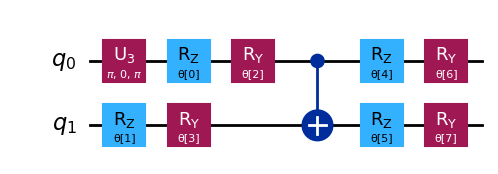

In [1]:

# https://learning.quantum.ibm.com/course/variational-algorithm-design/instances-and-extensions


from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable=SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [3]:

from cost_func import cost_func_vqe
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()


In [4]:

# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result



 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999988971089
       x: [ 1.779e+00  9.443e-01  1.571e+00  2.105e-05  1.938e+00
            1.204e+00  6.059e-01  6.059e-01]
    nfev: 136
   maxcv: 0.0

In [ ]:

from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)

print(backend)


<IBMBackend('ibm_kyiv')>


In [6]:

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)


In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, Options

#Estimated required time: <20 min. Benchmarked at 17 min, 40 s on ibm_osaka, on 5-29-24

x0 = np.ones(8)

with Session(backend=backend) as session:
    # session_options = Options()
    # session_options.default_shots = 4096
    # session_options.resilience_level = 1

    # estimator = Estimator(session=session)
    # sampler = Sampler(session = session)
    # estimator.options.default_shots = 10_000

    job = session.run(
        ansatz=isa_ansatz,
        observable=isa_observable,
        shots=10_000,
        estimator=estimator,
        )
    
    result = minimize(cost_func_vqe, x0, args=(isa_ansatz, isa_observable, estimator), method="COBYLA")

session.close()
print(result)

ValidationError: 1 validation error for OptionsV2
default_shots
  Object has no attribute 'default_shots' [type=no_such_attribute, input_value=4096, input_type=int]
    For further information visit https://errors.pydantic.dev/2.9/v/no_such_attribute